# <h2><center><strong style="color:#ff6161"> Data Cleaning </center></strong></h3>
 
    
<p> Environment: Python 3.7.4 and Jupyter notebook  </strong> 

### Importing the Libraries 

In [50]:
#initializing packages
import pandas as pd
import datetime
import math
from ast import literal_eval
import numpy as np
from numpy import linalg
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [51]:
#initializing variables
price_dict = {}
predicted_delivery_charge = []
outlier = []
predicted_outlier_df = pd.DataFrame()

# Based on the season's data 
Spring = ['September', 'October', 'November']
Summer = ['December', 'January', 'February']
Autumn = ['March', 'April', 'May']
Winter = ['June', 'July', 'August']

# Warehouse dictionary for the location co-ordinates

warehouse_dict = {'Nickolson' : [-37.818595,	144.969551],
                  'Thompson' : [-37.8126732,	144.9470689],
                  'Bakers' : [-37.8099961, 144.995232],
                  }

# Instantiate the Linear Regression Model
lm_for_Winter = LinearRegression() #instatiate
lm_for_Summer = LinearRegression()
lm_for_Autumn = LinearRegression()
lm_for_Spring = LinearRegression()

<h3> Reading Input Files 

In [52]:
#Reading dirty_data.csv file
dirty_df = pd.read_csv('31224075_dirty_data.csv')

#Reading missing_data.csv file
missing_df = pd.read_csv('31224075_missing_data.csv')

#Reading the outliers file
outlier_df = pd.read_csv('31224075_outlier_data.csv')

index = []

<h3> Statistical analysis for the data

In [53]:
dirty_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD372599,ID6167357883,2019-01-11,Nickolson,"[('iStream', 2), ('Universe Note', 1), ('Olivi...",8380,72.32,144.973927,-37.812895,0,8452.32,Summer,False,0.7421,so much phone for the money i was impressed th...,True
1,ORD303368,ID0207085868,2019-11-20,Bakers,"[('Toshika 750', 2), ('iStream', 2), ('Olivia ...",11025,80.98,-37.810458,145.011527,15,9452.23,Spring,False,1.4340,five stars just what i wanted - thanks,True
2,ORD133972,ID2658548178,2019-04-24,Thompson,"[('pearTV', 2), ('iAssist Line', 2)]",17070,68.19,-37.803835,144.963002,10,15431.19,Autumn,True,1.7122,still not fixed i love the phone but the scree...,False
3,ORD329995,ID0370749842,2019-09-18,Bakers,"[('pearTV', 1), ('Toshika 750', 1), ('Lucent 3...",15315,87.89,-37.814073,144.985729,0,15402.89,Spring,True,0.9510,received with a bad battery. . i received this...,False
4,ORD216595,ID1889062696,2019-11-12,Bakers,"[('Candle Inferno', 1), ('Olivia x460', 1), ('...",4135,58.65,-37.809613,144.991366,10,3780.15,Spring,False,0.3426,"phone was supposed to be factory unlocked, cam...",False


In [54]:
print("Dirty Data Shape : ", dirty_df.shape ,"\n")

print(dirty_df.columns)


Dirty Data Shape :  (500, 16) 

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer'],
      dtype='object')


<h4>The data has 500 rows and 16 columns

In [55]:
print(dirty_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              500 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    500 non-null    int64  
 6   delivery_charges               500 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    500 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

In [56]:
#As seen here in the data frame the Int for order_price needs to be converted to Float 

#Converting the order_price column to float to match the schema
dirty_df['order_price'] =dirty_df['order_price'].astype(float)


In [57]:
#Checking for non numeric columns
dirty_df.describe(include=['object', 'bool'])

,order_id,customer_id,date,nearest_warehouse,shopping_cart,season,is_expedited_delivery,latest_customer_review,is_happy_customer
count,500,500,500,500,500,500,500,500,500
unique,500,488,297,6,455,8,2,500,2
top,ORD036468,ID2005895269,2019-12-26,Thompson,"[('Alcon 10', 2), ('Lucent 330S', 1)]",Winter,True,five stars great refurbished product!!,True
freq,1,2,5,197,4,123,267,1,372


<h4> Here nearest_warehouse has 6 unique keys whereas there can only be 3 different names, So there's a possiblity of misspelling or other Grammar errors.

In [58]:
dirty_df.nearest_warehouse.unique()

array(['Nickolson', 'Bakers', 'Thompson', 'thompson', 'bakers',
       'nickolson'], dtype=object)

<h4> Syntactic Anomalies are found here with some capital and non-capital names.

In [59]:
#To check the customer satisfaction 
dirty_df['is_happy_customer'].value_counts()

True     372
False    128
Name: is_happy_customer, dtype: int64

In [60]:
dirty_df.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,13815.880000,78.107600,-27.942411,135.096118,10.920000,12213.393720,1.090723
std,8038.048268,15.116409,41.352891,41.352993,8.602418,7296.763853,0.512969
min,580.000000,47.060000,-37.826842,-37.831490,0.000000,551.970000,0.093600
25%,7170.000000,66.302500,-37.818792,144.949491,5.000000,6376.262500,0.725025
50%,13107.500000,77.840000,-37.812771,144.963028,10.000000,11390.000000,1.023650
75%,18580.000000,87.845000,-37.804627,144.978368,15.000000,16505.820000,1.418775
max,41870.000000,112.630000,145.015963,145.020570,25.000000,39848.530000,2.874600


<h4 >It is known that the numbers are in decimal degrees format and range from -90 to 90 for latitude and -180 to 180 for longitude. </h4>

As seen for the customer latitude and longitude data, there seems to be an outlier of max and min range respectively. The data here needs to be looked upon. 


<h3> For Missing Data Analysis

In [61]:
missing_df.head()

,order_id,customer_id,date,nearest_warehouse,shopping_cart,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,season,is_expedited_delivery,distance_to_nearest_warehouse,latest_customer_review,is_happy_customer
0,ORD243748,ID0267319466,2019-08-08,NaN,"[('Universe Note', 2), ('Candle Inferno', 1)]",7330.0,77.45,-37.826252,144.971522,0,7407.45,Winter,True,NaN,love this candle. it is my fourth candle and i...,1.0
1,ORD488070,ID1728565028,2019-01-13,Thompson,"[('Candle Inferno', 2), ('Toshika 750', 1), ('...",8780.0,77.51,-37.823325,144.953335,0,8857.51,Summer,False,1.3075,a good buy for people looking for just a simpl...,1.0
2,ORD436776,ID2841675062,2019-12-19,Nickolson,"[('iStream', 1), ('Toshika 750', 1)]",NaN,73.90,-37.809687,144.963647,15,NaN,Summer,False,1.1193,bought this for my wife for our anniversary sh...,1.0
3,ORD053160,ID0635492069,2019-04-27,Thompson,"[('Universe Note', 1), ('Thunder line', 1)]",5630.0,63.02,-37.814370,144.939015,25,4285.52,Autumn,True,0.7330,listed as an at&t phone. this is a sprint ... ...,0.0
4,ORD191125,ID6226313838,2019-02-09,Nickolson,"[('iStream', 1), ('Toshika 750', 2)]",8790.0,97.89,-37.818636,144.982767,0,8887.89,Summer,True,1.1621,it's so efficient and amazing! how cool! we ...,1.0


In [62]:
print("Missing Data Shape : ", missing_df.shape ,"\n")

print(missing_df.columns)


Missing Data Shape :  (500, 16) 

Index(['order_id', 'customer_id', 'date', 'nearest_warehouse', 'shopping_cart',
       'order_price', 'delivery_charges', 'customer_lat', 'customer_long',
       'coupon_discount', 'order_total', 'season', 'is_expedited_delivery',
       'distance_to_nearest_warehouse', 'latest_customer_review',
       'is_happy_customer'],
      dtype='object')


In [63]:
print(missing_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       500 non-null    object 
 1   customer_id                    500 non-null    object 
 2   date                           500 non-null    object 
 3   nearest_warehouse              445 non-null    object 
 4   shopping_cart                  500 non-null    object 
 5   order_price                    485 non-null    float64
 6   delivery_charges               460 non-null    float64
 7   customer_lat                   500 non-null    float64
 8   customer_long                  500 non-null    float64
 9   coupon_discount                500 non-null    int64  
 10  order_total                    485 non-null    float64
 11  season                         500 non-null    object 
 12  is_expedited_delivery          500 non-null    boo

<h4> As seen of the 500 rows for data. Some columns have less than 500 rows, indicating missing values in them .

In [64]:
missing_df.isna().sum()

order_id                          0
customer_id                       0
date                              0
nearest_warehouse                55
shopping_cart                     0
order_price                      15
delivery_charges                 40
customer_lat                      0
customer_long                     0
coupon_discount                   0
order_total                      15
season                            0
is_expedited_delivery             0
distance_to_nearest_warehouse    31
latest_customer_review            0
is_happy_customer                40
dtype: int64

<h3> Missing data leads to Coverage Anomalies which can be avoided by finding the cause of missing values or by finding the mean or close approximation to that value in the population.

<h4> As seen there are misssing records in the columns : nearest_warehouse, delivery_charges, order_price, order_total, distance_to_nearest_warehouse, is_happy_customer. 


In [65]:
#Checking for non-numeric columns
missing_df.describe(include=['object', 'bool'])

,order_id,customer_id,date,nearest_warehouse,shopping_cart,season,is_expedited_delivery,latest_customer_review
count,500,500,500,445,500,500,500,500
unique,500,493,268,3,460,4,2,500
top,ORD219713,ID3106293102,2019-12-19,Thompson,"[('Olivia x460', 1), ('Universe Note', 2)]",Summer,False,two stars i don't like this product for the re...
freq,1,2,6,196,4,132,253,1


In [66]:
#To check the overall customer satisfaction 
missing_df['is_happy_customer'].value_counts()

1.0    338
0.0    122
Name: is_happy_customer, dtype: int64

In [67]:
missing_df.describe()

,order_price,delivery_charges,customer_lat,customer_long,coupon_discount,order_total,distance_to_nearest_warehouse,is_happy_customer
count,485.000000,460.000000,500.000000,500.000000,500.000000,485.000000,469.000000,460.000000
mean,13647.051546,76.663565,-37.812207,144.965873,11.290000,12117.760515,1.064973,0.734783
std,8211.122607,14.729531,0.007747,0.020868,8.691201,7261.113049,0.492287,0.441930
min,580.000000,47.770000,-37.832570,144.925726,0.000000,590.380000,0.050400,0.000000
25%,6920.000000,65.275000,-37.818525,144.950859,5.000000,6355.290000,0.701900,0.000000
50%,12215.000000,76.060000,-37.812245,144.963433,10.000000,10839.600000,1.040200,1.000000
75%,19125.000000,84.127500,-37.805876,144.981392,15.000000,16791.190000,1.402900,1.000000
max,40385.000000,111.200000,-37.788265,145.016324,25.000000,38485.000000,3.138800,1.000000


<h3> Further detecting the errors/anamolies for the data. 

In [68]:
# Coppying the data frame to alter and make changes to find different analysis for the error data. 
dirty_eda = dirty_df
dirty_eda['date'].head(20)

0     2019-01-11
1     2019-11-20
2     2019-04-24
3     2019-09-18
4     2019-11-12
5     2019-07-16
6     2019-08-02
7     2019-10-08
8     2019-06-30
9     2019-05-26
10    2019-03-05
11    2019-10-14
12    2019-25-02
13    2019-12-20
14    2019-10-28
15    2019-12-26
16    2019-08-25
17    2019-10-12
18    2019-09-23
19    2019-05-10
Name: date, dtype: object

As seen we are unsure about the date for 2019-25-02 when it comes to months and day representation. This can be edited with converting the date to datetime format with a special input.

dirty_eda['date'] = pd.to_datetime(dirty_eda['date'], dayfirst= True)

This is a case of syntatic error. 

Now for the seasons column, there seems to be a mismatch when it comes to assigning the seasons based on months.



In [69]:
#As seen for some of the data in Dates and the Seasons there is a mismatch when it comes to assigning the seasons based on months

dirty_eda['month'] = pd.to_datetime(dirty_eda['date'], dayfirst= True).dt.month

summer_months = [12,1,2]
winter_months = [6,7,8]
a = dirty_eda[~dirty_eda.month.isin(summer_months)][['date','season']]
a[a.season == 'Summer']

b = dirty_eda[~dirty_eda.month.isin(winter_months)][['date','season']]
b[b.season == 'Winter']


,date,season
420,2019-11-29,Winter


There is a semantic error observed for the wrongful entry of season values. Here seen for month November, however winter months were from June to August.

In [70]:
dirty_eda[['customer_lat', 'customer_long']].head(15)

,customer_lat,customer_long
0,144.973927,-37.812895
1,-37.810458,145.011527
2,-37.803835,144.963002
3,-37.814073,144.985729
4,-37.809613,144.991366
5,-37.813636,145.000079
6,-37.824632,144.984665
7,-37.820726,144.941532
8,-37.818962,145.008436
9,-37.803496,144.994822


As seen for the customer latitude and longitude values, the latitude and longitudes seem to be visibly interchanged. This can be a case of invalid tuples when considering the location for it. And should be rectified.

Similarly for column values descrepancies can be found in order_total, distance_between_the_warehouse these calculations can be made to look for potential synctatic errors. 

Also to check for If the customer is happy or not we need to find the compound score for the Sentimental Analysis. For a compound score of greater than 0.5 the customer is valued to be happy. 

In [71]:
#function for finding Column : 'is_happy_customer' values


def is_happy_customer(text):
    SIA = SentimentIntensityAnalyzer()
    score = SIA.polarity_scores(text)
    #print(score['compound'])
    #Rules include if a customer has no previous review or the score is greater than 0.05 then the customer is happy
    if (score['compound'] >= 0.05) or (text == 'None'):
        return True
    else:
        return False


In the below function I'm calculating the item_price for each of the items in the shopping cart. But since, missing data has no anomalies when it comes to the item price, I've considered the use of missing data file here for calculations. 

In [72]:
#function for generating shopping cart price list
def item_price() :
    
    #looping through missing_data to compare the product list with inner loop
    for i in range(0,len(missing_df)):
        
        #converting shopping cart value : (product, count) from string to list
        cart1 = sorted(literal_eval(missing_df.shopping_cart.values[i]))
        #storing products as list 
        product_list1 = [product[0] for product in cart1]
    
        #ending loop if price list for all items are calculated 
        if(len(price_dict) == 10):
            break
        
        #skipping rows with order_price having blank values 
        if(math.isnan(missing_df.order_price.values[i])):
            continue
        
        #looping through missing_data to compare the product list with outer loop
        for j in range(0,len(missing_df)):
            
            #skipping rows with order_price having blank values  
            if(math.isnan(missing_df.order_price.values[j])):
                continue
            
            #initializing variables
            cost = 0
            cart_list = []
            notin_list = []
            
            cart2 = sorted(literal_eval(missing_df.shopping_cart.values[j]))
            product_list2 = [product[0] for product in cart2]
         
            #finding list of products not there in either product_list
            item = set(product_list1).symmetric_difference(set(product_list2))
            
            #finding list of products in cart2 with price missing
            for product in cart2:
                if product[0] in price_dict.keys():
                    #print(product)
                    cart_list.append(product[0])
                    cost += price_dict[product[0]]*product[1]
                    #print(cost)
                else:
                    notin_list.append(product)
            
            #calculating price if only 1 product in cart2 is missing price
            if(len(notin_list) == 1):
                #calculating product price
                p = (missing_df.order_price.values[j]-cost)/notin_list[0][1]
                #saving the product and price to price_dict
                price_dict[notin_list[0][0]] = abs(int(p))
            
            #checking if products in both product_lists are same or not
            elif (len(item) == 0) :
                
                #storing count of product as a matrix
                product_count = np.array([[product[1] for product in cart1], [product[1] for product in cart2]])
                #storing order total price for both product list as a matrix
                total_price = np.array([missing_df.order_price.values[i], missing_df.order_price.values[j]])
                #converting both product and total_price matrix into a square matrix
                sq_product_count = np.zeros((max(product_count.shape), max(product_count.shape)))
                sq_product_count[:product_count.shape[0],:product_count.shape[1]] = product_count
                
                sq_total_price = np.zeros((max(product_count.shape)))
                sq_total_price[:total_price.shape[0]] = total_price
                
                try:
                    price = linalg.solve(sq_product_count, sq_total_price)
                    for k in range(len(price)):
                        price_dict[product_list1[k]] = abs(int(price[k])) 
                except linalg.LinAlgError as err:
                    if 'Singular matrix' in str(err):
                        #reinitializing lists to avoid duplication on err
                        cart_list = []
                        notin_list = []
                
                #reinitialiting lists to avoid duplication 
                cart_list = []
                notin_list = []


Calculating the order_price by verifying the sum of individual item price and it's units. 

In [73]:
#function for finding Column : 'order_price' values

def order_price(item_list):
    #print(literal_eval(item_list))
    item_list = literal_eval(item_list)
    price = 0
    for value in item_list:
        # Verifying the order price with the item order count and the price for it to get the total
        price += price_dict[value[0]]*value[1]
        
    #print('total',price)
    return price


Calculating the order_total by substracting the discount price and then adding the delivery charge for each of the discounted price. 

In [74]:
#function for finding Column : 'order_total' values

# Calculating the order total after applying the coupon discount and then adding the delivery charges

def order_total(order_price, discount, delivery_charge):
    
    discounted_price = (100 - discount)/100 * order_price
    total_price = discounted_price + delivery_charge
    #print(total_price)
    
    return total_price


As seen from the statistical analysis, there was a inconsistency with the the lat long values, which on further investigation we found that the lat long values were interchanged. 

In [75]:
#function for finding Column : lat_long' values

# Checking for irregularities in latitudes and longitudes
# Swapping the values for lat and long if latitude values are greater and less than -90

#The numbers are in decimal degrees format and range from -90 to 90 for latitude and -180 to 180 for longitude.

def lat_long(lat, long):
    if lat > 90 or lat < -90:
        #print(lat)
        lat = lat + long
        long = lat - long
        lat = lat - long
    
    return lat, long


Function to calculate the Havesian distance between the two locations i.e the customer and warehouse location. 

In [76]:
#Calculating the nearest distance between the customer and warehouse using the Havesian distance

def distance_to_nearest_warehouse(warehouse, lat, long):
    #Fetching the warehouse coordinates from the warehouse dict
    warehouse_coordinates = warehouse_dict[warehouse]
    
    #Converting the float lat long values to radians
    customer_lat = math.radians(lat)
    customer_long = math.radians(long)
    warehouse_lat = math.radians(warehouse_coordinates[0])
    warehouse_long = math.radians(warehouse_coordinates[1])
    
    # Applying Havesian distance formula to find the distance between the customer and warehouse co-ordinates
    dlat = customer_lat - warehouse_lat
    dlong = customer_long - warehouse_long
    a = math.sin(dlat / 2)**2 + math.cos(warehouse_lat) * math.cos(customer_lat) * math.sin(dlong / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = 6378.0 * c
    #print(distance)
    
    # Approximation to upto 4 decimal places
    round_distance = round(distance,4)
    #print (round_distance)
    
    return round_distance

Function to find the nearest warehouse from the customer and warehouse locations. The warehouse location is retreived from the stored warehouse dict. 

In [77]:
#function for finding Column : 'nearest_warehouse' values

# To impute the missing values for nearest warehouse column  

def nearest_warehouse(lat, long):
    temp_warehouse = {}
    for warehouse, coordinates in warehouse_dict.items():
        warehouse_coordinates = coordinates
        #print(warehouse_coordinates)
        customer_lat = math.radians(lat)
        customer_long = math.radians(long)
        warehouse_lat = math.radians(warehouse_coordinates[0])
        warehouse_long = math.radians(warehouse_coordinates[1])
        
        # Finding the Havesian distance 
        dlat = customer_lat - warehouse_lat
        dlong = customer_long - warehouse_long
        a = math.sin(dlat / 2)**2 + math.cos(warehouse_lat) * math.cos(customer_lat) * math.sin(dlong / 2)**2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = 6378.0 * c
        #print(distance)
        round_distance = round(distance,4)
        
        # Storing the calculated distance as the key and warehouse name as the value in the temp dict
        temp_warehouse[round_distance] = warehouse
    
    # Sorting and fetching the least distance value for the warehouse location
    nearest_wh = sorted(temp_warehouse.items())[0]
    #print(nearest_wh[1])
    return nearest_wh[1]



As seen for the season inconsistencies with the the dates(months). Season values are calculated based on the dates.

In [78]:
#Function for finding Column : 'season' values    

#Checking for the values of month in the list of seasons month list initialized at the start. 

def season(date, season):
    #print(date)    
    date = datetime.datetime.strptime(str(date)[:10], '%Y-%m-%d')
    #print(date.strftime('%B'))
    if date.strftime('%B') in Spring:
        if season != 'Spring':
            #print('Spring', season)
            season = 'Spring'
    elif date.strftime('%B') in Summer:
        #print('Summer')
        if season != 'Summer':
            season = 'Summer'
    elif date.strftime('%B') in Autumn:
        #print('Autumn')
        if season != 'Autumn':
            season = 'Autumn'
    elif date.strftime('%B') in Winter:
        #print('Winter')
        if season != 'Winter':
            season = 'Winter'

    return season


 <h2> Processing for the Dirty Data File : 

In [79]:
#Calling fn to create item price list     
item_price()

#As some values have a precision greater than 4 , to keep the data consistent , removing the 
dirty_df['distance_to_nearest_warehouse'] = dirty_df['distance_to_nearest_warehouse'].round(decimals=4)

#Storing a temporary variable to store the values for the correct representation of date and time
d = pd.to_datetime(dirty_df['date'], dayfirst= True )


In [80]:
#Checking and updating the inconsistent values from the dirty data file

#If a record is updated then the function skips to the next row in the data frame and doesn't check for errors in other columns

for i in range(0,len(dirty_df)):
    
    #capitalizing nearest_warehouse values
    if dirty_df.nearest_warehouse.values[i] != dirty_df.nearest_warehouse.values[i].capitalize():
        dirty_df.nearest_warehouse.values[i] == dirty_df.nearest_warehouse.values[i].capitalize()
        #index.append(i)
        continue  
   
    #Checking for the date column irregularities
    if d[i].strftime('%Y-%m-%d') != dirty_df.date[i]:
        dirty_df.date[i] = pd.to_datetime(dirty_df['date'][i], dayfirst= True )
        dirty_df.date[i] = dirty_df.date[i].strftime('%Y-%m-%d')
        #index.append(i)
        #print(dirty_df.date[i])
        continue
    
    
    temp_season = season(dirty_df.date.values[i], dirty_df.season.values[i])
    if temp_season != dirty_df.season.values[i]:
        dirty_df.season.values[i] = temp_season
        #index.append(i)
        continue
    
    temp_lat, temp_long = lat_long(dirty_df.customer_lat.values[i], dirty_df.customer_long.values[i])
    if temp_lat != dirty_df.customer_lat.values[i]:
        dirty_df.customer_lat.values[i] = temp_lat 
        dirty_df.customer_long.values[i] = temp_long
        #index.append(i)
        continue
    
    temp_distance = distance_to_nearest_warehouse(dirty_df.nearest_warehouse.values[i], dirty_df.customer_lat.values[i], dirty_df.customer_long.values[i])
    if temp_distance != dirty_df.distance_to_nearest_warehouse.values[i]:
        dirty_df.distance_to_nearest_warehouse.values[i] = temp_distance
        #index.append(i)
        continue
        
        
    temp_warehouse = nearest_warehouse(dirty_df.customer_lat.values[i], dirty_df.customer_long.values[i])
    if temp_warehouse != dirty_df.nearest_warehouse.values[i]:
        dirty_df.nearest_warehouse.values[i] = temp_warehouse
        #index.append(i)
        #continue    

    temp_is_happy = is_happy_customer(dirty_df.latest_customer_review.values[i])
    if temp_is_happy != dirty_df.is_happy_customer.values[i]:
        dirty_df.is_happy_customer.values[i] = temp_is_happy
        #index.append(i)
        continue
    

    temp_price = order_price(dirty_df.shopping_cart.values[i])
    if temp_price != dirty_df.order_price.values[i]:
        dirty_df.order_price.values[i] = temp_price
        #index.append(i)
        continue
    
    temp_total = order_total(dirty_df.order_price.values[i], dirty_df.coupon_discount.values[i], dirty_df.delivery_charges.values[i])
    if temp_total != dirty_df.order_total.values[i]:
        dirty_df.order_total.values[i] = temp_total
        #index.append(i)
        continue

dirty_df['date'] = pd.to_datetime(dirty_df['date'], dayfirst= True )    
#Saving dirty_data dataframe as .csv file
dirty_df.to_csv('31224075_dirty_data_solution.csv', index = False)



<ipython-input-80-84c7e907ec0f>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_df.date[i] = pd.to_datetime(dirty_df['date'][i], dayfirst= True )
<ipython-input-80-84c7e907ec0f>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dirty_df.date[i] = dirty_df.date[i].strftime('%Y-%m-%d')


<h2> Imputing values for Missing Data : </h2>

Here, all the missing values in the columns are quite random and can be imputed as they are calculations and some are dependent on others. 

The delivery_charges column is linearly dependent on is_expedited_delivery, distance_to_nearest_warehouse and is_happy_customer and the linear model hence made will depend in different ways for different seasons.

Hence 4 different linear models will be made for 4 different seasons. 


In [81]:

#function to initialize linear_model
def init_linear_model(dataframe):
    #print(dataframe)
    #Creating a subset for the dataframe already transformed for all the other values of the data frame
    model_df = dataframe[['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','delivery_charges','season']]
    #Deleting records containing nan values for columns other than delivery charges
    model_df.dropna(subset=['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','season'],axis=0,inplace=True)
    
    #Deleting the records containing nan fields for delivery charges
    model_df.dropna(subset=['delivery_charges'],axis=0,inplace=True)
    
    #Assigning the model to be passed to the linear model based on season
    lm_fitting_Winter_df = model_df.loc[model_df['season'] == 'Winter']
    lm_fitting_Summer_df = model_df.loc[model_df['season'] == 'Summer']
    lm_fitting_Autumn_df = model_df.loc[model_df['season'] == 'Autumn']
    lm_fitting_Spring_df = model_df.loc[model_df['season'] == 'Spring']
    
    #storing train_test_split output
    x_train_winter, x_test_winter, y_train_winter, y_test_winter = train_test_split(lm_fitting_Winter_df[[x for x in lm_fitting_Winter_df.columns if x != 'delivery_charges' and x!= 'season']],lm_fitting_Winter_df['delivery_charges'], test_size=0.50, random_state=7)
    x_train_summer, x_test_summer, y_train_summer, y_test_summer = train_test_split(lm_fitting_Summer_df[[x for x in lm_fitting_Summer_df.columns if x != 'delivery_charges' and x!= 'season']],lm_fitting_Summer_df['delivery_charges'], test_size=0.33, random_state=7)
    x_train_autumn, x_test_autumn, y_train_autumn, y_test_autumn = train_test_split(lm_fitting_Autumn_df[[x for x in lm_fitting_Autumn_df.columns if x != 'delivery_charges' and x!= 'season']],lm_fitting_Autumn_df['delivery_charges'], test_size=0.33, random_state=7)
    x_train_spring, x_test_spring, y_train_spring, y_test_spring = train_test_split(lm_fitting_Spring_df[[x for x in lm_fitting_Spring_df.columns if x != 'delivery_charges' and x!= 'season']],lm_fitting_Spring_df['delivery_charges'], test_size=0.33, random_state=7)
    
    # Fit the linear model with the training data frame and the test dataframe
    lm_for_Winter.fit(x_train_winter, y_train_winter) #fit
    lm_for_Summer.fit(x_train_summer, y_train_summer) #fit
    lm_for_Autumn.fit(x_train_autumn, y_train_autumn) #fit
    lm_for_Spring.fit(x_train_spring, y_train_spring) #fit


In [82]:
#calling function to initialize train dataset
init_linear_model(missing_df)

<ipython-input-81-7d4917f9c2b7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(subset=['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','season'],axis=0,inplace=True)
<ipython-input-81-7d4917f9c2b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(subset=['delivery_charges'],axis=0,inplace=True)


In [83]:
def predict(index, dataframe):
    #creating a subset of dataframe with required columns
    data = dataframe.loc[index, ['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','delivery_charges','season']]
    #adding column names to the dataframe
    model_df_impute = pd.DataFrame([data], columns=['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','delivery_charges','season'])

    if(model_df_impute['season'].item() == 'Winter'):
        # Predicting the values for the test column 
        predict_charge = lm_for_Winter.predict(model_df_impute.drop(['delivery_charges', 'season'],axis=1)) 
        
    if(model_df_impute['season'].item() == 'Summer'):
        # Predicting the values for the test column 
        predict_charge = lm_for_Summer.predict(model_df_impute.drop(['delivery_charges', 'season'],axis=1))
   
    if(model_df_impute['season'].item() == 'Autumn'):
        # Predicting the values for the test column 
        predict_charge = lm_for_Autumn.predict(model_df_impute.drop(['delivery_charges', 'season'],axis=1))
  
    if(model_df_impute['season'].item() == 'Spring'):
        # Predicting the values for the test column 
        predict_charge = lm_for_Spring.predict(model_df_impute.drop(['delivery_charges', 'season'],axis=1)) 
   
    
    return predict_charge[0].round(decimals=2)



Predict function is called on the linear model to predict the target values for the missing fields.

<h3> Imputing Missing values </h3>

Imputing the missing data values for the columns having nulls in their value fields. 

In [84]:
for i in range(0,len(missing_df)):
    
    #creating a list of column names with null values 
    temp_df = pd.DataFrame([missing_df.values[i]], columns = missing_df.columns)
    null_columns = temp_df.columns[temp_df.isna().any()].tolist()

    for columns in null_columns:
        if columns == 'nearest_warehouse':
            missing_df.nearest_warehouse.values[i] = nearest_warehouse(missing_df.customer_lat.values[i], missing_df.customer_long.values[i])
   
        if columns == 'order_price':
            missing_df.order_price.values[i] = order_price(missing_df.shopping_cart.values[i])

        if columns == 'delivery_charges':
            missing_df.delivery_charges.values[i] = predict(i, missing_df)
       
        if columns == 'order_total':
            missing_df.order_total.values[i] = order_total(missing_df.order_price.values[i], missing_df.coupon_discount.values[i], missing_df.delivery_charges.values[i])
            
        if columns == 'distance_to_nearest_warehouse':
            missing_df.distance_to_nearest_warehouse.values[i] = distance_to_nearest_warehouse(missing_df.nearest_warehouse.values[i], missing_df.customer_lat.values[i], missing_df.customer_long.values[i])
            
        if columns == 'is_happy_customer':
            missing_df.is_happy_customer.values[i] = is_happy_customer(missing_df.latest_customer_review.values[i])
        
#Saving dirty_data dataframe as .csv file
missing_df.to_csv('31224075_missing_data_solution.csv', index = False)


<h3> Verifying for all the missing values.

In [85]:
missing_df.isna().any()

order_id                         False
customer_id                      False
date                             False
nearest_warehouse                False
shopping_cart                    False
order_price                      False
delivery_charges                 False
customer_lat                     False
customer_long                    False
coupon_discount                  False
order_total                      False
season                           False
is_expedited_delivery            False
distance_to_nearest_warehouse    False
latest_customer_review           False
is_happy_customer                False
dtype: bool

<h2> Processing for Outlier Data </h2>

For the outliers data, as we need to consider only for the delivery_orders column, we can predict the outliers by finding the linear regression model for the outlier data values. And plotting the residuals i.e. the difference between the actual and the predicted values for the data based on seasons. 

In [86]:
#calling function to initialize train dataset
init_linear_model(outlier_df)

<ipython-input-81-7d4917f9c2b7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(subset=['distance_to_nearest_warehouse','is_expedited_delivery','is_happy_customer','season'],axis=0,inplace=True)
<ipython-input-81-7d4917f9c2b7>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df.dropna(subset=['delivery_charges'],axis=0,inplace=True)


In [87]:
for i in range(0,len(outlier_df)):
    charge = predict(i, outlier_df)
    #appending predicted delivery_charges onto a list
    predicted_delivery_charge.append(charge)

In [88]:
#creating a dataframe with predicted and actual delivery_charges
predicted_df = predicted_outlier_df.assign(order_id = outlier_df['order_id'], predicted = predicted_delivery_charge, actual = outlier_df['delivery_charges'], season = outlier_df['season'])


<h4> Plotting the residual plot between the predicted and the actual data.

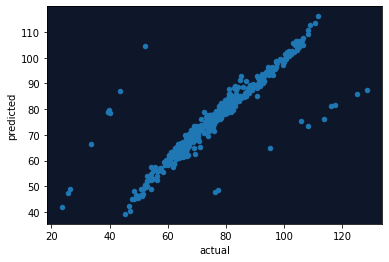

In [89]:
plot = predicted_df.plot.scatter(
    x = 'actual', y = 'predicted',
    legend=False
    #color='dr_light_blue',
)
plot.set_facecolor('#0E162A')


<h4> We now calculate the residual score which is the difference between the predicted and the actual values. 

In [90]:
#finding and storing difference between predicted and actual delivery_charges
predicted_df['difference'] = (predicted_df['predicted'] - predicted_df['actual'])


<h4> Plotting the residual score for the 4 different seasons to check for outliers in the data. 

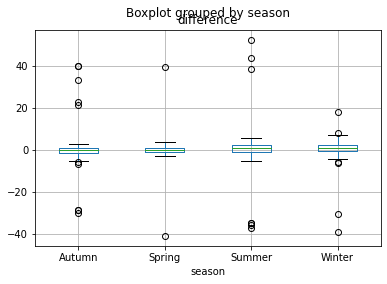

In [91]:
#ploting the diff against season 
box_plot = predicted_df.boxplot(column='difference', by = 'season')
plt.show()

<h3> Function to find the outliers using interquartile range (IQR) and removing all the residual scores which are greater than the upper_limit and scores which are lesser than the lower limit. 

In [92]:
#generate outliers
def outlier_detection(data):
    Q1 = data['difference'].quantile(0.25)
    Q3 = data['difference'].quantile(0.75)
    IQR = Q3 -Q1
    upper_limit = Q3+1.5*IQR
    lower_limit = Q1-1.5*IQR
    for i in range(0,len(data)):
        if (data.difference.values[i]) > upper_limit or (data.difference.values[i]) < lower_limit :
            outlier.append(data.order_id.values[i])
        
                

In [93]:
#Finding the outliers for each of the predicted 

#calling function to generate outliers based on season
outlier_detection(predicted_df.loc[predicted_df['season'] == 'Winter'])
outlier_detection(predicted_df.loc[predicted_df['season'] == 'Summer'])
outlier_detection(predicted_df.loc[predicted_df['season'] == 'Autumn'])
outlier_detection(predicted_df.loc[predicted_df['season'] == 'Spring'])

In [94]:
#removing outlier
for i in outlier:
    #print(len(outlier))
    if i in outlier_df.values:
        outlier_df.drop(outlier_df.loc[outlier_df['order_id']==i].index, inplace=True)
   

In [95]:
#Saving outlier_data dataframe as .csv file
outlier_df.to_csv('31224075_outlier_data_solution.csv', index = False)

In [96]:
len(outlier_df)

475

<h2> After removing the outliers from the data. 

In [97]:
#removing outlier
for i in outlier:
    
    if i in predicted_df.values:
        predicted_df.drop(predicted_df.loc[predicted_df['order_id']==i].index, inplace=True)

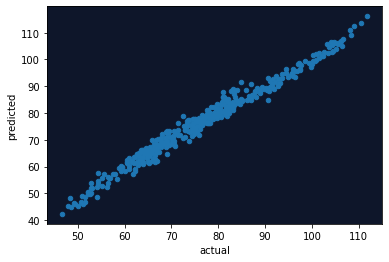

In [98]:
plot = predicted_df.plot.scatter(
    x = 'actual', y = 'predicted',
    legend=False
    #color='dr_light_blue',
)
plot.set_facecolor('#0E162A')


<h2> Refrences: 

1. https://datarobot-public-api-client.readthedocs-hosted.com/en/v2.21.5/examples/advanced_model_insights_regression/Advanced_Model_Insights_Regression.html

2. https://medium.com/swlh/identify-outliers-with-pandas-statsmodels-and-seaborn-2766103bf67c
3. https://scikit-learn.org/stable/modules/impute.html